## Image Denoising Project (VLG)

**Deliverables:**
* You must include the training code for your model. Using pre-trained models is not allowed.
* Report your own scores- MSE, PSNR and MAE on the training dataset


**Overview:**

Light is of paramount importance to photography. Night and low light place very demanding constraints on photography due to very limited photon count and inescapable noise. One natural reaction is to gather more light by, e.g., enlarging aperture setting, lengthening exposure time and opening flashlight. However, each method brings a trade-off–large aperture incurs small depth of field, and is usually unavailable in smartphone cameras; long exposure can induce blur due to scene variations or camera motions; flash can cause color aberrations and is useful only for nearby objects. Therefore, denoising in extremely low-light conditions has become an important research direction in the low-level image processing community, aiming to restore details in images captured in extremely low-light scenes and enhance visual quality.

Importing all libraries

In [4]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

***Using Grayscale Images***

In [3]:
low_light_folder = '/kaggle/input/training/Train_mod/Train/low'
high_light_folder = '/kaggle/input/training/Train_mod/Train/high'
image_size = (256, 256)

In [4]:
def load_and_preprocess_image(image_path, target_size):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0
    return image

In [5]:
def load_images(folder, target_size):
    images = []
    for filename in tqdm(sorted(os.listdir(folder))):
        if filename.endswith(".png"):
            image_path = os.path.join(folder, filename)
            image = load_and_preprocess_image(image_path, target_size)
            images.append(image)
    return np.array(images)

In [6]:
low_images = load_images(low_light_folder, image_size)
high_images = load_images(high_light_folder, image_size)

100%|██████████| 482/482 [00:07<00:00, 64.26it/s]


In [7]:
low_light_images = low_images.reshape(-1, image_size[0], image_size[1], 1)
high_light_images = high_images.reshape(-1, image_size[0], image_size[1], 1)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(low_light_images, high_light_images, test_size=0.1, random_state=42)

In [3]:
from skimage.metrics import peak_signal_noise_ratio as psnr

## UNET (Model 1)

**U-Net is an architecture for semantic segmentation. It consists of a contracting path and an expansive path. The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution. At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. In total the network has 23 convolutional layers.**

In [4]:
from tensorflow.keras.layers import Add,Multiply
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

Below is the basic UNET architecture (model) without any modifications.

In [11]:
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    
    return model

In [12]:
model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss=MeanSquaredError())

Importing a test dataset comprising of 3 random images.

In [11]:
low_light_test = '/kaggle/input/testing/Test_mod/X_test'
high_light_test = '/kaggle/input/testing/Test_mod/Y_test'

In [12]:
X_test = load_images(low_light_test, image_size)
y_test = load_images(high_light_test, image_size)

100%|██████████| 3/3 [00:00<00:00, 62.52it/s]


In [13]:
X_test = X_test.reshape(-1, image_size[0], image_size[1], 1)
y_test = y_test.reshape(-1, image_size[0], image_size[1], 1)

In [16]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8)

Epoch 1/50


I0000 00:00:1718253656.630285     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 ━━━━━━━━━━━━━━━━━━━━ 80s 517ms/step - loss: 0.0434 - val_loss: 0.0276
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - loss: 0.0266 - val_loss: 0.0242
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - loss: 0.0243 - val_loss: 0.0272
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - loss: 0.0248 - val_loss: 0.0266
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 0.0276 - val_loss: 0.0218
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - loss: 0.0233 - val_loss: 0.0222
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - loss: 0.0223 - val_loss: 0.0222
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - loss: 0.0217 - val_loss: 0.0202
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - loss: 0.0205 - val_loss: 0.0197
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - loss: 0.0182 - val_loss: 0.0198
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - loss: 0.0173 - val_loss: 0.0200
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - loss: 

In [17]:
predictions = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


Below is the PSNR score generated on the test dataset (3 random images were picken for this purpose).

In [18]:
psnr_values = [psnr(y_true, y_pred) for y_true, y_pred in zip(y_test, predictions)]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

Average PSNR: 18.161406378045317


**The main UNET variation used which produced the best PSNR among all grayscale images.**

Below is the modified UNET architecture with inclusion of residual block.

In [12]:
def residual_block(input_tensor, filters):
    x = Conv2D(filters, 3, activation='relu', padding='same')(input_tensor)
    x = Conv2D(filters, 3, activation=None, padding='same')(x)
    x = Add()([x, input_tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [13]:
def unet_model_with_residuals(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = residual_block(conv1, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = residual_block(conv2, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = residual_block(conv3, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = residual_block(conv4, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = residual_block(conv5, 512)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = residual_block(conv6, 256)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = residual_block(conv7, 128)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = residual_block(conv8, 64)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = residual_block(conv9, 32)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

Below is the UNET variation with batch normalization (eventually not considered due to poorer PSNR score).

In [14]:
def residual_block(x, filters):
    res = Conv2D(filters, 3, padding='same', activation=None)(x)
    res = BatchNormalization()(res)
    res = tf.keras.activations.relu(res)
    res = Conv2D(filters, 3, padding='same', activation=None)(res)
    res = BatchNormalization()(res)
    res = Add()([res, x])
    res = tf.keras.activations.relu(res)
    return res

def unet_model_with_residuals_and_bn_modified(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation=None, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.activations.relu(conv1)
    conv1 = residual_block(conv1, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation=None, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.activations.relu(conv2)
    conv2 = residual_block(conv2, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation=None, padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = tf.keras.activations.relu(conv3)
    conv3 = residual_block(conv3, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation=None, padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = tf.keras.activations.relu(conv4)
    conv4 = residual_block(conv4, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation=None, padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = tf.keras.activations.relu(conv5)
    conv5 = residual_block(conv5, 512)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, 3, activation=None, padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = tf.keras.activations.relu(conv6)
    conv6 = residual_block(conv6, 256)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, 3, activation=None, padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = tf.keras.activations.relu(conv7)
    conv7 = residual_block(conv7, 128)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, 3, activation=None, padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = tf.keras.activations.relu(conv8)
    conv8 = residual_block(conv8, 64)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, 3, activation=None, padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = tf.keras.activations.relu(conv9)
    conv9 = residual_block(conv9, 32)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

# Create the model
model = unet_model_with_residuals_and_bn_modified()

# Compile the model with a lower learning rate and gradient clipping
optimizer = Adam(learning_rate=1e-5, clipvalue=1.0)
model.compile(optimizer=optimizer, loss=MeanSquaredError())

# Ensure TensorFlow uses the GPU efficiently
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [1]:
# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )
# def data_generator(low_light_images, high_light_images, batch_size):
#     datagen.fit(low_light_images)
#     for low_light_batch, high_light_batch in datagen.flow(low_light_images, high_light_images, batch_size=batch_size):
#         yield (low_light_batch, high_light_batch)

Data augmentation was tried too but it did not improve the PSNR score.

**Below is the training part of the UNET variation producing the best PSNR score amongst grayscale images.**

In [22]:
model1 = unet_model_with_residuals()
model1.compile(optimizer=Adam(learning_rate=1e-4), loss=MeanSquaredError())
batch_size = 8
epochs = 50
model1.fit(X_train, y_train,
          epochs=epochs, batch_size=8)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 28s 292ms/step - loss: 0.0425
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step - loss: 0.0348
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - loss: 0.0276
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - loss: 0.0252
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 217ms/step - loss: 0.0202
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - loss: 0.0238
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - loss: 0.0177
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step - loss: 0.0178
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - loss: 0.0184
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - loss: 0.0195
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - loss: 0.0165
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step - loss: 0.0185
Epoch 13/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 217ms/step - loss: 0.0166
Epoch 14/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step - loss: 0.0161
Epoch 15/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 

Below is the model training of the other UNET variation.

In [15]:
 unet_model = unet_model_with_residuals_and_bn_modified()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0)
unet_model.compile(optimizer=optimizer, loss=MeanSquaredError())
batch_size = 8
epochs = 50
unet_model.fit(X_train, y_train,
          epochs=epochs, batch_size=8)

Epoch 1/50


2024-06-14 10:53:36.572495: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.39938, expected 0.737369
2024-06-14 10:53:36.572550: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.22844, expected 1.56643
2024-06-14 10:53:36.572559: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.5773, expected 1.91529
2024-06-14 10:53:36.572567: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.31412, expected 1.65211
2024-06-14 10:53:36.572574: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.54633, expected 1.88432
2024-06-14 10:53:36.572582: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.04715, expected 2.38514
2024-06-14 10:53:36.572590: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.26879, expected 1.60678
2024-06-14 10:53:36.572597: E external/local_xla/xla/se

 1/55 ━━━━━━━━━━━━━━━━━━━━ 37:41 42s/step - loss: 0.1159

I0000 00:00:1718362438.495218     144 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0484

2024-06-14 10:54:06.863329: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 0.878312, expected 0.570809
2024-06-14 10:54:06.863382: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 1.93885, expected 1.63135
2024-06-14 10:54:06.863391: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 1.95887, expected 1.65137
2024-06-14 10:54:06.863399: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65543: 2.00731, expected 1.69981
2024-06-14 10:54:06.863406: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65544: 1.51439, expected 1.20689
2024-06-14 10:54:06.863415: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65545: 1.53933, expected 1.23182
2024-06-14 10:54:06.863423: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65546: 1.5939, expected 1.2864
2024-06-14 10:54:06.863430:

55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 353ms/step - loss: 0.0479
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0236
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0194
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0194
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0179
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0181
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0160
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0162
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0159
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0158
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0151
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0137
Epoch 13/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0147
Epoch 14/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0138
Epoch 15/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0124

In [16]:
predictions1 = unet_model.predict(X_val)
psnr_values = [psnr(y_true, y_pred) for y_true, y_pred in zip(y_val, predictions1)]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

2024-06-14 10:59:31.350463: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.7617, expected 0.989329
2024-06-14 10:59:31.350515: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.3675, expected 1.59513
2024-06-14 10:59:31.350532: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.99184, expected 2.21947
2024-06-14 10:59:31.350551: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.27093, expected 2.49857
2024-06-14 10:59:31.350565: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.95602, expected 2.18365
2024-06-14 10:59:31.350576: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.29863, expected 2.52627
2024-06-14 10:59:31.350587: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.57151, expected 2.79914
2024-06-14 10:59:31.350597: E external/local_xla/xla/ser

1/2 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step

2024-06-14 10:59:49.581859: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.4497, expected 0.589987
2024-06-14 10:59:49.581911: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.56345, expected 1.70373
2024-06-14 10:59:49.581927: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.72804, expected 1.86833
2024-06-14 10:59:49.581940: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.84308, expected 1.98336
2024-06-14 10:59:49.581950: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.065, expected 2.20528
2024-06-14 10:59:49.581961: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.94159, expected 2.08188
2024-06-14 10:59:49.581972: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.12099, expected 2.26128
2024-06-14 10:59:49.581981: E external/local_xla/xla/serv

2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 10s/step
Average PSNR: 21.0726584844431


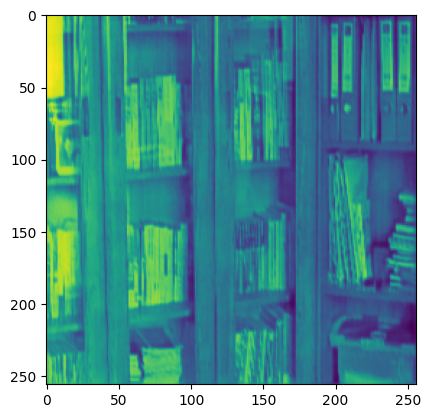

In [26]:
z = predictions1[1]
plt.imshow(z)

Randomly displayed image simply to compare predicted image and the actual image (in grayscale)

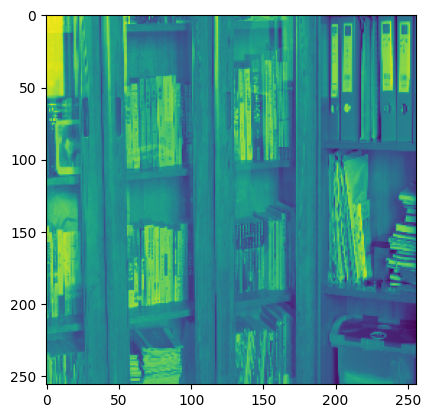

In [27]:
plt.imshow(y_test[1])

In [28]:
predictions2 = model1.predict(X_val)
psnr_values = [psnr(y_true, y_pred) for y_true, y_pred in zip(y_val, predictions2)]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

2024-06-13 06:28:45.106293: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,96,256,256]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-13 06:28:45.505088: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.39889934s
Trying algorithm eng0{} for conv (f32[32,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,96,256,256]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
20

2/2 ━━━━━━━━━━━━━━━━━━━━ 99s 36s/step
Average PSNR: 21.940884201988073


In [14]:
def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, (2, 2), strides=(2, 2), padding='same')(x)
    phi_g = Conv2D(inter_channel, (1, 1), padding='same')(g)
    add_xg = tf.keras.layers.Add()([theta_x, phi_g])
    act_xg = tf.keras.layers.Activation('relu')(add_xg)
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tf.keras.layers.Activation('sigmoid')(psi)
    upsample_psi = UpSampling2D(size=(2, 2))(sigmoid_xg)
    attn_coefficients = Multiply()([x, upsample_psi])
    return attn_coefficients
def residual_block(x, filters):
    res = Conv2D(filters, 3, padding='same', activation='relu')(x)
    res = Conv2D(filters, 3, padding='same')(res)
    res = Add()([res, x])
    return res

The attention block did not improve the PSNR score.

It was observed that increasing the number of filters (doubling) did not increase the PSNR score as done below.

In [15]:
def residual_block(x, filters):
    res = Conv2D(filters, 3, padding='same', activation=None)(x)
    res = BatchNormalization()(res)
    res = tf.keras.activations.relu(res)
    res = Conv2D(filters, 3, padding='same', activation=None)(res)
    res = BatchNormalization()(res)
    res = Add()([res, x])
    res = tf.keras.activations.relu(res)
    return res

def unet_model_with_residuals_and_bn(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation=None, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.activations.relu(conv1)
    conv1 = residual_block(conv1, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation=None, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.activations.relu(conv2)
    conv2 = residual_block(conv2, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation=None, padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = tf.keras.activations.relu(conv3)
    conv3 = residual_block(conv3, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation=None, padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = tf.keras.activations.relu(conv4)
    conv4 = residual_block(conv4, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation=None, padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = tf.keras.activations.relu(conv5)
    conv5 = residual_block(conv5, 1024)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(512, 3, activation=None, padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = tf.keras.activations.relu(conv6)
    conv6 = residual_block(conv6, 512)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(256, 3, activation=None, padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = tf.keras.activations.relu(conv7)
    conv7 = residual_block(conv7, 256)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(128, 3, activation=None, padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = tf.keras.activations.relu(conv8)
    conv8 = residual_block(conv8, 128)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, 3, activation=None, padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = tf.keras.activations.relu(conv9)
    conv9 = residual_block(conv9, 64)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    optimizer = Adam(learning_rate=1e-4, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss=MeanSquaredError())

    return model

# Assuming X_train and y_train are your input images and corresponding labels


# Train the model
unet = unet_model_with_residuals_and_bn()
unet.fit(X_train, y_train, batch_size=8, epochs=50, validation_split=0.1)


Epoch 1/50


2024-06-14 10:17:58.812128: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.58222, expected 0.737369
2024-06-14 10:17:58.812205: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.41128, expected 1.56643
2024-06-14 10:17:58.812215: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.76015, expected 1.91529
2024-06-14 10:17:58.812223: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.49696, expected 1.65211
2024-06-14 10:17:58.812230: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.72918, expected 1.88432
2024-06-14 10:17:58.812239: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.22999, expected 2.38514
2024-06-14 10:17:58.812247: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.45164, expected 1.60678
2024-06-14 10:17:58.812254: E external/local_xla/xla/s

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.0354

2024-06-14 10:18:57.588706: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.06306, expected 0.587185
2024-06-14 10:18:57.588770: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.37522, expected 1.89934
2024-06-14 10:18:57.588779: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.49553, expected 2.01965
2024-06-14 10:18:57.588786: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.35389, expected 1.87801
2024-06-14 10:18:57.588794: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.81771, expected 2.34183
2024-06-14 10:18:57.588801: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.83996, expected 2.36408
2024-06-14 10:18:57.588809: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.48233, expected 2.00645
2024-06-14 10:18:57.588816: E external/local_xla/xla/s

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - loss: 0.0353

2024-06-14 10:19:30.105544: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 0.961309, expected 0.421057
2024-06-14 10:19:30.105597: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 2.31528, expected 1.77503
2024-06-14 10:19:30.105606: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 2.17812, expected 1.63786
2024-06-14 10:19:30.105614: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65539: 2.11732, expected 1.57707
2024-06-14 10:19:30.105622: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65540: 2.64766, expected 2.1074
2024-06-14 10:19:30.105629: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65541: 2.68691, expected 2.14665
2024-06-14 10:19:30.105637: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65542: 2.00241, expected 1.46216
2024-06-14 10:19:30.105644

49/49 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - loss: 0.0351 - val_loss: 0.0489
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 313ms/step - loss: 0.0204 - val_loss: 0.0470
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - loss: 0.0210 - val_loss: 0.0527
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - loss: 0.0185 - val_loss: 0.0530
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 315ms/step - loss: 0.0171 - val_loss: 0.0545
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 315ms/step - loss: 0.0181 - val_loss: 0.0560
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 315ms/step - loss: 0.0161 - val_loss: 0.0520
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 315ms/step - loss: 0.0151 - val_loss: 0.0628
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 315ms/step - loss: 0.0155 - val_loss: 0.0543
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 315ms/step - loss: 0.0150 - val_loss: 0.0361
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 315ms/step - loss: 0.0146 - val_loss: 0.0360
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 315ms/step 

In [16]:
predictions_unet = unet.predict(X_val)
psnr_values = [psnr(y_true, y_pred) for y_true, y_pred in zip(y_val, predictions_unet)]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

2024-06-14 10:32:23.188321: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 1.05936, expected 0.681349
2024-06-14 10:32:23.188384: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 2.21753, expected 1.83952
2024-06-14 10:32:23.188400: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 2.5462, expected 2.16819
2024-06-14 10:32:23.188414: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65539: 2.07291, expected 1.6949
2024-06-14 10:32:23.188432: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65540: 2.56529, expected 2.18728
2024-06-14 10:32:23.188443: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65542: 2.19261, expected 1.8146
2024-06-14 10:32:23.188453: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65543: 1.83463, expected 1.45662
2024-06-14 10:32:23.188463: E

1/2 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step

2024-06-14 10:33:14.017555: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.09454, expected 0.589987
2024-06-14 10:33:14.017610: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.20828, expected 1.70373
2024-06-14 10:33:14.017619: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.37288, expected 1.86833
2024-06-14 10:33:14.017627: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.48791, expected 1.98336
2024-06-14 10:33:14.017634: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.70983, expected 2.20528
2024-06-14 10:33:14.017641: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.58643, expected 2.08188
2024-06-14 10:33:14.017649: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.76583, expected 2.26128
2024-06-14 10:33:14.017656: E external/local_xla/xla/s

2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 26s/step
Average PSNR: 20.76535665112812


20.390922299624567 with 30 epochs


20.76535665112812 with 50 epochs

**UNET Further Tuning**

In [15]:
from tensorflow.keras.losses import Huber

Running the code on the UNET variation (the one with the residual layers).

In [17]:
model = unet_model_with_residuals()
model.compile(optimizer=Adam(learning_rate=1e-4, clipvalue=1.0), loss=Huber())
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

In [19]:
model.fit(X_train, y_train,epochs=50, batch_size=8)

Epoch 1/50


I0000 00:00:1718430708.230904     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 ━━━━━━━━━━━━━━━━━━━━ 92s 587ms/step - loss: 0.0198
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - loss: 0.0149
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - loss: 0.0117
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - loss: 0.0106
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - loss: 0.0112
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - loss: 0.0101
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - loss: 0.0098
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - loss: 0.0094
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - loss: 0.0086
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - loss: 0.0080
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - loss: 0.0080
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - loss: 0.0091
Epoch 13/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - loss: 0.0081
Epoch 14/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - loss: 0.0072
Epoch 15/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step 

In [20]:
prediction = model.predict(X_val)
psnr_values = [psnr(y_true, y_pred) for y_true, y_pred in zip(y_val, prediction)]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

2024-06-15 06:02:26.077544: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,96,256,256]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-15 06:02:26.366673: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.289322663s
Trying algorithm eng0{} for conv (f32[32,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,96,256,256]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2

2/2 ━━━━━━━━━━━━━━━━━━━━ 92s 35s/step
Average PSNR: 22.013915340419327


In [16]:
from tensorflow.keras.optimizers import SGD

In [16]:
def residual_block_new(input_tensor, filters):
    x = Conv2D(filters, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = Dropout(0.5)(x)  # Add Dropout layer
    x = Conv2D(filters, 3, activation=None, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Add()([x, input_tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [23]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Add, Input
from tensorflow.keras.models import Model

In [24]:
def unet_model_with_residuals_new(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(inputs)
    conv1 = residual_block_new(conv1, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(pool1)
    conv2 = residual_block_new(conv2, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(pool2)
    conv3 = residual_block_new(conv3, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(pool3)
    conv4 = residual_block_new(conv4, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(pool4)
    conv5 = residual_block_new(conv5, 512)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(up6)
    conv6 = residual_block_new(conv6, 256)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(up7)
    conv7 = residual_block_new(conv7, 128)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(up8)
    conv8 = residual_block_new(conv8, 64)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(up9)
    conv9 = residual_block_new(conv9, 32)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

Various kinds of losses were tried and Binary cross entropy loss showed best result relatively.

In [20]:
from tensorflow.image import ssim
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(ssim(y_true, y_pred, max_val=1.0))

In [28]:
def psnr_loss(y_true, y_pred):
    return 10.0 * tf.math.log(tf.reduce_mean(tf.square(y_pred - y_true))) / tf.math.log(10.0)

In [14]:
from tensorflow.keras.losses import MeanAbsoluteError
mae_loss = MeanAbsoluteError()

In [17]:
from tensorflow.keras.losses import BinaryCrossentropy
bce_loss = BinaryCrossentropy(from_logits=True)

In [25]:
# from tensorflow.keras import regularizers
# model_latest = unet_model_with_residuals()
# optimizer=Adam(learning_rate=1e-4, clipvalue=1.0)
# l1_l2_regularizer = regularizers.l1_l2(l1=0.01, l2=0.01) 
# for layer in model_latest.layers:
#     if hasattr(layer, 'kernel_regularizer'):
#         layer.kernel_regularizer = l1_l2_regularizer
# model_latest.compile(optimizer=optimizer, loss='mean_squared_error')
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.compat.v1.InteractiveSession(config=config)
# model_latest.fit(X_train, y_train,epochs=60, batch_size=8)

Epoch 1/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 311ms/step - loss: 0.0409
Epoch 2/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - loss: 0.0268
Epoch 3/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - loss: 0.0243
Epoch 4/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - loss: 0.0224
Epoch 5/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - loss: 0.0198
Epoch 6/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - loss: 0.0196
Epoch 7/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - loss: 0.0175
Epoch 8/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step - loss: 0.0182
Epoch 9/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step - loss: 0.0172
Epoch 10/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - loss: 0.0164
Epoch 11/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - loss: 0.0158
Epoch 12/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - loss: 0.0170
Epoch 13/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - loss: 0.0157
Epoch 14/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - loss: 0.0181
Epoch 15/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 

In [21]:
model_latest = unet_model_with_residuals()
model_latest.compile(optimizer=Adam(learning_rate=1e-4, clipvalue=1.0), loss=bce_loss)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)
model_latest.fit(X_train, y_train, epochs=60, batch_size=8)

Epoch 1/75
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 310ms/step - loss: 0.6855
Epoch 2/75
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 233ms/step - loss: 0.6514
Epoch 3/75
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - loss: 0.6522
Epoch 4/75
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - loss: 0.6398
Epoch 5/75
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - loss: 0.6389
Epoch 6/75
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - loss: 0.6371
Epoch 7/75
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - loss: 0.6290
Epoch 8/75
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step - loss: 0.6285
Epoch 9/75
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step - loss: 0.6336
Epoch 10/75
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - loss: 0.6262
Epoch 11/75
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - loss: 0.6362
Epoch 12/75
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - loss: 0.6219
Epoch 13/75
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - loss: 0.6231
Epoch 14/75
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 227ms/step - loss: 0.6305
Epoch 15/75
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 

In [21]:
prediction = model_latest.predict(X_val)
psnr_values = [psnr(y_true, y_pred) for y_true, y_pred in zip(y_val, prediction)]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Average PSNR: 22.566101809168583


Above is Mean Absolute Error at 60 epochs.

In [16]:
prediction = model_latest.predict(X_val)
psnr_values = [psnr(y_true, y_pred) for y_true, y_pred in zip(y_val, prediction)]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

2024-06-15 10:12:25.994790: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,96,256,256]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-15 10:12:26.471708: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.477031284s
Trying algorithm eng0{} for conv (f32[32,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,96,256,256]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2

2/2 ━━━━━━━━━━━━━━━━━━━━ 102s 38s/step
Average PSNR: 22.598547568007916


BCE at 60 epochs (above)

In [19]:
prediction = model_latest.predict(X_val)
psnr_values = [psnr(y_true, y_pred) for y_true, y_pred in zip(y_val, prediction)]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Average PSNR: 22.831217277115773


This was the best PSNR score for grayscale images.

In [26]:
prediction = model_latest.predict(X_val)
psnr_values = [psnr(y_true, y_pred) for y_true, y_pred in zip(y_val, prediction)]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Average PSNR: 22.092913000015056


## Denoising Convolutional Neural Network(DnCNN) (Model 2)

**We take one step forward by investigating the construction of feed-forward denoising convolutional neural networks (DnCNNs) to embrace the progress in very deep architecture, learning algorithm, and regularization method into image denoising. Specifically, residual learning and batch normalization are utilized to speed up the training process as well as boost the denoising performance. Different from the existing discriminative denoising models which usually train a specific model for additive white Gaussian noise (AWGN) at a certain noise level, our DnCNN model is able to handle Gaussian denoising with unknown noise level (i.e., blind Gaussian denoising). With the residual learning strategy, DnCNN implicitly removes the latent clean image in the hidden layers. This property motivates us to train a single DnCNN model to tackle with several general image denoising tasks such as Gaussian denoising, single image super-resolution and JPEG image deblocking.**

In [17]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization

In [18]:
# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )
# def data_generator(low_light_images, high_light_images, batch_size):
#     datagen.fit(low_light_images)
#     for low_light_batch, high_light_batch in datagen.flow(low_light_images, high_light_images, batch_size=batch_size):
#         yield (low_light_batch, high_light_batch)


Here too, data augmentation did not improve PSNR.

In [23]:
def dncnn_model(input_size=(256, 256, 1), depth=20, filters=64):
    inputs = Input(input_size)
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
    x = Activation('relu')(x)
    for _ in range(depth - 2):
        x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = Conv2D(1, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    model = Model(inputs, x)
    return model

In [24]:
dncnn = dncnn_model()
dncnn.compile(optimizer=Adam(learning_rate=1e-5), loss=MeanSquaredError())

In [25]:
dncnn.fit(X_train, y_train, batch_size=8, epochs=30)

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 51s 646ms/step - loss: 0.7283
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 575ms/step - loss: 0.4493
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 591ms/step - loss: 0.2919
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 599ms/step - loss: 0.2008
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 595ms/step - loss: 0.1478
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 595ms/step - loss: 0.1125
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 596ms/step - loss: 0.0911
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 597ms/step - loss: 0.0741
Epoch 9/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 598ms/step - loss: 0.0639
Epoch 10/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 597ms/step - loss: 0.0570
Epoch 11/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 597ms/step - loss: 0.0533
Epoch 12/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 597ms/step - loss: 0.0481
Epoch 13/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 597ms/step - loss: 0.0434
Epoch 14/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 597ms/step - loss: 0.0415
Epoch 15/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 

In [22]:
dncnn_preds = dncnn.predict(X_val)
psnr_values = [psnr(y_true, y_pred) for y_true, y_pred in zip(y_val, dncnn_preds)]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step
Average PSNR: 17.956827312966013


Above is the psnr with simple model

In [27]:
dncnn_preds = dncnn.predict(X_train)
psnr_values = [psnr(y_true, y_pred) for y_true, y_pred in zip(y_train, dncnn_preds)]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 599ms/step
Average PSNR: 16.140251188000395


In [26]:
dncnn_preds = dncnn.predict(X_val)
psnr_values = [psnr(y_true, y_pred) for y_true, y_pred in zip(y_val, dncnn_preds)]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Average PSNR: 16.114564032539228


## Residual Channel Attention Network(RCAN) (Model 3)

**A residual in residual (RIR) structure is proposed to form very deep network, which consists of several residual groups with long skip connections. Each residual group contains some residual blocks with short skip connections.
Furthermore, a channel attention mechanism is proposed to adaptively rescale channel-wise features by considering interdependencies among channels.**

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

In [10]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += identity
        return out

class RCAN(nn.Module):
    def __init__(self, num_channels=3, num_features=64, num_residual_blocks=16, num_groups=10):
        super(RCAN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_features, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.residual_blocks = nn.Sequential(*[ResidualBlock(num_features) for _ in range(num_residual_blocks)])
        self.conv2 = nn.Conv2d(num_features, num_channels, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.residual_blocks(out)
        out = self.conv2(out)
        return out

class ImagePairDataset(torch.utils.data.Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        self.input_images = sorted(os.listdir(input_dir))
        self.target_images = sorted(os.listdir(target_dir))

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        input_image_path = os.path.join(self.input_dir, self.input_images[idx])
        target_image_path = os.path.join(self.target_dir, self.target_images[idx])

        input_image = Image.open(input_image_path).convert('RGB')
        target_image = Image.open(target_image_path).convert('RGB')

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RCAN().to(device)

print(f"Number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = amp.GradScaler()
num_epochs = 20
accumulation_steps = 4

input_dir = '/kaggle/input/training/Train_mod/Train/low'
target_dir = '/kaggle/input/training/Train_mod/Train/high'

transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor()           
])

train_dataset = ImagePairDataset(input_dir=input_dir, target_dir=target_dir, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

model.train()
for epoch in range(num_epochs):
    print(f'Starting epoch {epoch + 1}')
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_dataloader, 0):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        with amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i + 1) % 10 == 0:  
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_dataloader)}], Loss: {running_loss / 10:.4f}')
            running_loss = 0.0
print('Finished Training')

Number of learnable parameters: 1185219
Starting epoch 1
Epoch [1/20], Step [10/31], Loss: 0.4393
Epoch [1/20], Step [20/31], Loss: 0.0879
Epoch [1/20], Step [30/31], Loss: 0.0453
Starting epoch 2
Epoch [2/20], Step [10/31], Loss: 0.0685
Epoch [2/20], Step [20/31], Loss: 0.0517
Epoch [2/20], Step [30/31], Loss: 0.0359
Starting epoch 3
Epoch [3/20], Step [10/31], Loss: 0.0590
Epoch [3/20], Step [20/31], Loss: 0.0381
Epoch [3/20], Step [30/31], Loss: 0.0362
Starting epoch 4
Epoch [4/20], Step [10/31], Loss: 0.0518
Epoch [4/20], Step [20/31], Loss: 0.0331
Epoch [4/20], Step [30/31], Loss: 0.0359
Starting epoch 5
Epoch [5/20], Step [10/31], Loss: 0.0365
Epoch [5/20], Step [20/31], Loss: 0.0342
Epoch [5/20], Step [30/31], Loss: 0.0375
Starting epoch 6
Epoch [6/20], Step [10/31], Loss: 0.0615
Epoch [6/20], Step [20/31], Loss: 0.0315
Epoch [6/20], Step [30/31], Loss: 0.0329
Starting epoch 7
Epoch [7/20], Step [10/31], Loss: 0.0548
Epoch [7/20], Step [20/31], Loss: 0.0435
Epoch [7/20], Step [3

In [17]:
image_size = (256,256)
X_test = load_images('/kaggle/input/testing/Test_mod/X_test', image_size)
y_test = load_images('/kaggle/input/testing/Test_mod/Y_test', image_size)

100%|██████████| 3/3 [00:00<00:00, 52.46it/s]


In [20]:
def load_images(image_dir, image_size):
    images = []
    for file_name in sorted(os.listdir(image_dir)):
        file_path = os.path.join(image_dir, file_name)
        image = Image.open(file_path).convert('RGB')
        image = image.resize(image_size)
        image = np.array(image)
        images.append(image)
    images = np.stack(images, axis=0)
    images = torch.tensor(images, dtype=torch.float32) / 255.0 
    images = images.permute(0, 3, 1, 2)
    return images

image_size = (256, 256)
X_test = load_images('/kaggle/input/testing/Test_mod/X_test', image_size)
y_test = load_images('/kaggle/input/testing/Test_mod/Y_test', image_size)
X_test = X_test.to(device)
model.eval()
with torch.no_grad():
    y_eval = model(X_test)
y_eval = y_eval.cpu().numpy()
print(y_eval.shape)

(3, 3, 256, 256)


In [23]:
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(1.0 / torch.sqrt(mse))
y_test = y_test.to(device)
model.eval()
with torch.no_grad():
    y_eval = model(X_test)
psnr_values = []
for i in range(len(y_eval)):
    psnr = calculate_psnr(y_eval[i], y_test[i])
    psnr_values.append(psnr.item())
average_psnr = sum(psnr_values) / len(psnr_values)
print(f'Average PSNR: {average_psnr:.4f}')

Average PSNR: 14.5733


In [28]:
def load_images(image_dir, image_size):
    images = []
    for file_name in sorted(os.listdir(image_dir)):
        file_path = os.path.join(image_dir, file_name)
        image = Image.open(file_path).convert('RGB')
        image = image.resize(image_size)
        image = np.array(image)
        images.append(image)
    images = np.stack(images, axis=0)
    images = torch.tensor(images, dtype=torch.float32) / 255.0 
    images = images.permute(0, 3, 1, 2) 
    return images

image_size = (256, 256)
X_test = load_images('/kaggle/input/training/Train_mod/Train/low', image_size)[10:60]
y_test = load_images('/kaggle/input/training/Train_mod/Train/high', image_size)[10:60]
X_test = X_test.to(device)
model.eval()
with torch.no_grad():
    y_eval = model(X_test)
y_eval = y_eval.cpu().numpy()
print(y_eval.shape)

(50, 3, 256, 256)


In [29]:
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(1.0 / torch.sqrt(mse))
y_test = y_test.to(device)
model.eval()
with torch.no_grad():
    y_eval = model(X_test)
psnr_values = []
for i in range(len(y_eval)):
    psnr = calculate_psnr(y_eval[i], y_test[i])
    psnr_values.append(psnr.item())
average_psnr = sum(psnr_values) / len(psnr_values)
print(f'Average PSNR: {average_psnr:.4f}')

Average PSNR: 13.0460


In [11]:
import torch.optim as optim
import torch.cuda.amp as amp
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += identity
        return out

class RCAN(nn.Module):
    def __init__(self, num_channels=3, num_features=64, num_residual_blocks=8, num_groups=5):
        super(RCAN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_features, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.residual_blocks = nn.Sequential(*[ResidualBlock(num_features) for _ in range(num_residual_blocks)])
        self.conv2 = nn.Conv2d(num_features, num_channels, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.residual_blocks(out)
        out = self.conv2(out)
        return out

class ImagePairDataset(torch.utils.data.Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        self.input_images = sorted(os.listdir(input_dir))
        self.target_images = sorted(os.listdir(target_dir))

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        input_image_path = os.path.join(self.input_dir, self.input_images[idx])
        target_image_path = os.path.join(self.target_dir, self.target_images[idx])

        input_image = Image.open(input_image_path).convert('RGB')
        target_image = Image.open(target_image_path).convert('RGB')

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RCAN().to(device)
print(f"Number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = amp.GradScaler()
torch.backends.cudnn.benchmark = True
num_epochs = 20
input_dir = '/kaggle/input/training/Train_mod/Train/low'
target_dir = '/kaggle/input/training/Train_mod/Train/high'
transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor()           
])
train_dataset = ImagePairDataset(input_dir=input_dir, target_dir=target_dir, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
model.train()
for epoch in range(num_epochs):
    print(f'Starting epoch {epoch + 1}')
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_dataloader, 0):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        with amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        if (i + 1) % 10 == 0: 
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_dataloader)}], Loss: {running_loss / 10:.4f}')
            running_loss = 0.0

print('Finished Training')
image_size = (256, 256)
X_test = load_images('/kaggle/input/testing/Test_mod/X_test', image_size)
y_test = load_images('/kaggle/input/testing/Test_mod/Y_test', image_size)
X_test = X_test.to(device)
model.eval()
with torch.no_grad():
    y_eval = model(X_test)
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(1.0 / torch.sqrt(mse))
y_test = y_test.to(device)
psnr_values = []
for i in range(len(y_eval)):
    psnr = calculate_psnr(y_eval[i], y_test[i])
    psnr_values.append(psnr.item())
average_psnr = sum(psnr_values) / len(psnr_values)
print(f'Average PSNR: {average_psnr:.4f}')

Number of learnable parameters: 594371
Starting epoch 1
Epoch [1/20], Step [10/121], Loss: 0.0815
Epoch [1/20], Step [20/121], Loss: 0.0340
Epoch [1/20], Step [30/121], Loss: 0.0377
Epoch [1/20], Step [40/121], Loss: 0.0317
Epoch [1/20], Step [50/121], Loss: 0.0324
Epoch [1/20], Step [60/121], Loss: 0.0436
Epoch [1/20], Step [70/121], Loss: 0.0333
Epoch [1/20], Step [80/121], Loss: 0.0297
Epoch [1/20], Step [90/121], Loss: 0.0304
Epoch [1/20], Step [100/121], Loss: 0.0303
Epoch [1/20], Step [110/121], Loss: 0.0333
Epoch [1/20], Step [120/121], Loss: 0.0378
Starting epoch 2
Epoch [2/20], Step [10/121], Loss: 0.0350
Epoch [2/20], Step [20/121], Loss: 0.0324
Epoch [2/20], Step [30/121], Loss: 0.0443
Epoch [2/20], Step [40/121], Loss: 0.0349
Epoch [2/20], Step [50/121], Loss: 0.0357
Epoch [2/20], Step [60/121], Loss: 0.0276
Epoch [2/20], Step [70/121], Loss: 0.0301
Epoch [2/20], Step [80/121], Loss: 0.0224
Epoch [2/20], Step [90/121], Loss: 0.0293
Epoch [2/20], Step [100/121], Loss: 0.0291

100%|██████████| 3/3 [00:00<00:00, 54.80it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [13]:
def numpy_to_tensor(np_array):
    return torch.from_numpy(np_array)
image_size = (256, 256)
X_test_np = load_images('/kaggle/input/testing/Test_mod/X_test', image_size)
y_test_np = load_images('/kaggle/input/testing/Test_mod/Y_test', image_size)
X_test = [numpy_to_tensor(img) for img in X_test_np]
y_test = [numpy_to_tensor(img) for img in y_test_np]
X_test = torch.stack(X_test).to(device)
y_test = torch.stack(y_test).to(device)
model.eval()
with torch.no_grad():
    y_eval = model(X_test)
def calculate_psnr(img1, img2):
    mse = nn.functional.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(1.0 / torch.sqrt(mse))
psnr_values = []
for i in range(len(y_eval)):
    psnr = calculate_psnr(y_eval[i], y_test[i])
    psnr_values.append(psnr.item())
average_psnr = sum(psnr_values) / len(psnr_values)
print(f'Average PSNR: {average_psnr:.4f}')

100%|██████████| 3/3 [00:00<00:00, 117.77it/s]


Average PSNR: 17.8216


In [17]:
X_test = [numpy_to_tensor(img) for img in X_test_np]
y_test = [numpy_to_tensor(img) for img in y_test_np]
X_test = torch.stack(X_test).to(device)
y_test = torch.stack(y_test).to(device)
model.eval()
with torch.no_grad():
    y_eval = model(X_test)
def calculate_psnr(img1, img2):
    mse = nn.functional.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(1.0 / torch.sqrt(mse))
psnr_values = []
for i in range(len(y_eval)):
    psnr = calculate_psnr(y_eval[i], y_test[i])
    psnr_values.append(psnr.item())
average_psnr = sum(psnr_values) / len(psnr_values)
print(f'Average PSNR: {average_psnr:.4f}')

100%|██████████| 482/482 [00:03<00:00, 124.80it/s]

Average PSNR: 14.5249


## UNET (Model 1) - Final

***Using LAB image format***

In [5]:
from tensorflow.keras.layers import Add,Multiply
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError


In [6]:
import cv2
import os
import numpy as np
from tqdm import tqdm

low_light_folder = '/kaggle/input/training/Train_mod/Train/low'
high_light_folder = '/kaggle/input/training/Train_mod/Train/high'
image_size = (256, 256)

def load_and_preprocess_image(image_path, target_size):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB) 
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0
    return image

def load_images(folder, target_size):
    images = []
    for filename in tqdm(sorted(os.listdir(folder))):
        if filename.endswith(".png"):
            image_path = os.path.join(folder, filename)
            image = load_and_preprocess_image(image_path, target_size)
            images.append(image)
    return np.array(images)

low_images = load_images(low_light_folder, image_size)
high_images = load_images(high_light_folder, image_size)
low_light_images = low_images.reshape(-1, image_size[0], image_size[1], 3)
high_light_images = high_images.reshape(-1, image_size[0], image_size[1], 3)


100%|██████████| 482/482 [00:04<00:00, 111.92it/s]


In [7]:
X_train, X_val, y_train, y_val = train_test_split(low_light_images, high_light_images, test_size=0.1, random_state=42)

In [8]:
from tensorflow.keras.optimizers import SGD

In [9]:
from tensorflow.keras.losses import BinaryCrossentropy
bce_loss = BinaryCrossentropy(from_logits=True)

In [10]:
def residual_block_lab(input_tensor, filters):
    x = Conv2D(filters, 3, activation='relu', padding='same')(input_tensor)
    x = Conv2D(filters, 3, activation=None, padding='same')(x)
    x = Add()([x, input_tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def unet_model_with_residuals_lab(input_size=(256, 256, 3)):  # Updated input size for HSV images
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = residual_block_lab(conv1, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = residual_block_lab(conv2, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = residual_block_lab(conv3, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = residual_block_lab(conv4, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = residual_block_lab(conv5, 512)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = residual_block_lab(conv6, 256)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = residual_block_lab(conv7, 128)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = residual_block_lab(conv8, 64)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = residual_block_lab(conv9, 32)

    conv10 = Conv2D(3, 1, activation='sigmoid')(conv9)  # Updated output channels to 3 for HSV

    model = Model(inputs=[inputs], outputs=[conv10])

    return model


In [11]:
from tensorflow.keras.losses import MeanAbsoluteError

In [12]:
model_lab = unet_model_with_residuals_lab()
model_lab.compile(optimizer=Adam(learning_rate=1e-4, clipvalue=1.0), loss=MeanAbsoluteError())
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)
model_lab.fit(X_train, y_train,
          epochs=60, batch_size=8)

Epoch 1/60


I0000 00:00:1718480429.045589     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 ━━━━━━━━━━━━━━━━━━━━ 91s 593ms/step - loss: 0.0748
Epoch 2/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - loss: 0.0726
Epoch 3/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - loss: 0.0694
Epoch 4/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - loss: 0.0620
Epoch 5/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 214ms/step - loss: 0.0583
Epoch 6/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - loss: 0.0600
Epoch 7/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - loss: 0.0560
Epoch 8/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - loss: 0.0582
Epoch 9/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - loss: 0.0547
Epoch 10/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - loss: 0.0544
Epoch 11/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - loss: 0.0530
Epoch 12/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - loss: 0.0528
Epoch 13/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - loss: 0.0510
Epoch 14/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - loss: 0.0525
Epoch 15/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step 

In [46]:
prediction = model_lab.predict(X_val)
psnr_values = [psnr(y_true, y_pred) for y_true, y_pred in zip(y_val, prediction)]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Average PSNR: 24.416415113810793


In [13]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
predictions = model_lab.predict(low_light_images)
def calculate_metrics(true_images, predicted_images):
    mse_values = []
    psnr_values = []
    mae_values = []

    for true, pred in zip(true_images, predicted_images):
        mse = mean_squared_error(true.flatten(), pred.flatten())
        psnr = tf.image.psnr(true, pred, max_val=1.0).numpy()
        mae = mean_absolute_error(true.flatten(), pred.flatten())
        mse_values.append(mse)
        psnr_values.append(psnr)
        mae_values.append(mae)
    return np.mean(mse_values), np.mean(psnr_values), np.mean(mae_values)
mse, psnr, mae = calculate_metrics(high_light_images, predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Peak Signal-to-Noise Ratio (PSNR): {psnr}')
print(f'Mean Absolute Error (MAE): {mae}')

2024-06-15 19:53:35.994597: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,96,256,256]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-15 19:53:36.348117: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.35362026s
Trying algorithm eng0{} for conv (f32[32,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,96,256,256]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
20

16/16 ━━━━━━━━━━━━━━━━━━━━ 76s 951ms/step
Mean Squared Error (MSE): 0.00307708908803761
Peak Signal-to-Noise Ratio (PSNR): 26.07855987548828
Mean Absolute Error (MAE): 0.03400035202503204


***The final output.***

In [14]:
model_lab.save('unet_model_with_residuals_lab.h5')

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('unet_model_with_residuals_lab.h5')